# Spline Interpolation

In this notebook we will be looking at two more methods of interpolation, coming from the very well known library 'scipy.'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp

In [2]:
def f(x, y):
    return -np.exp(-(y-np.sin(x))**2)

In [3]:
x = np.linspace(-3, 3, 500)
y = np.linspace(-3, 3, 500)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

In [4]:
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X, Y, zs=Z)
# plt.show()

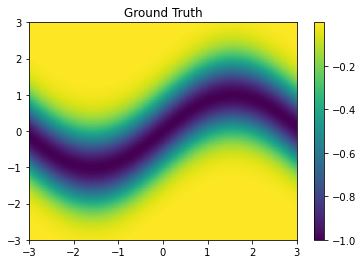

In [5]:
# color mesh map for ground truth
plt.pcolormesh(X, Y, Z, shading='auto')
plt.colorbar()
plt.title('Ground Truth')
plt.show()

In order to interpolate this function, I must artificially decrease the information I have of this surface. To do so, I will sample a grid of 20 points for $x$ and $y$ and use those as an input to the function as I have above, within the range (-3, 3). This should give a random smattering of points in the x,y plane, with accordance to the function $f$ as shown above.

Normally, I would use a randomized technique, but spline interpolation requires an ordered gridmesh of points. This greatly increases the barrier to use a spline technique, but the output is promising nonetheless.

In [6]:
# much of the following code is adapted from scipy.interpolate example code
# https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html

In [7]:
x_edges, y_edges = np.mgrid[-3:3:11j, -3:3:11j]
x = x_edges[:-1, :-1] + np.diff(x_edges[:2, 0])[0]*1.5
y = y_edges[:-1, :-1] + np.diff(y_edges[0, :2])[0] *1.5

In [8]:
z = f(x,y)

In [9]:
xnew_edges, ynew_edges = np.mgrid[-3:3:41j, -3:3:41j]
xnew = xnew_edges[:-1, :-1] + np.diff(xnew_edges[:2, 0])[0] *1.5
ynew = ynew_edges[:-1, :-1] + np.diff(ynew_edges[0, :2])[0] *1.5
tck = interp.bisplrep(x, y, z, s=0)
znew = interp.bisplev(xnew[:,0], ynew[0,:], tck)

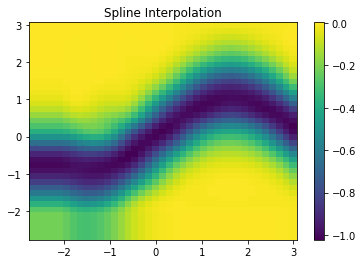

In [10]:
plt.pcolormesh(xnew, ynew, znew, shading='auto')
plt.title('Spline Interpolation')
plt.colorbar()
plt.show()

I'm not sure what's going on with first 7 or so columns of pixels (they are identical for one column to the next), but the rest of the interpolation looks fine.

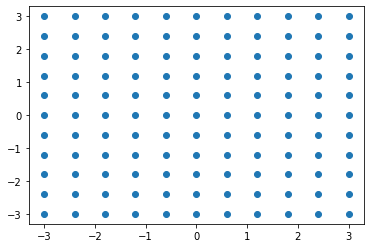

In [11]:
plt.scatter(x_edges, y_edges)
plt.show()

I will now compare the spline interpolation accuracy with a naive linear approach.

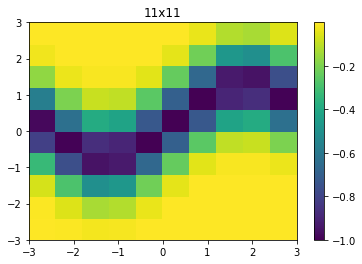

In [12]:

z_test = np.zeros((11, 11))
for i in range(11):
    for j in range(11):
        z_test[i][j] = f(x_edges[i][j], y_edges[i][j])
        

# test_arr = np.asarray([[1,2,3],[4,5,6],[7,8,9]])

def instantiate(arr2da, arr2db):
    for i in range(len(arr2da)):
        for j in range(len(arr2da[0])):
            arr2db[i*2][j*2] = arr2da[i][j]
    return arr2db
        
def increase_density(arr2d):
    sizeX = len(arr2d)
    sizeY = len(arr2d[0])
    newX = (sizeX-1)*2 + 1
    newY = (sizeY-1)*2 + 1
    arr2d_dense = np.zeros((newX, newY))
    arr2d_dense = instantiate(arr2d, arr2d_dense)
    
    for i in range(sizeX - 1):
        for j in range(sizeY - 1):
            arr2d_dense[i*2 + 1][j*2] = (arr2d_dense[i*2][j*2] + arr2d_dense[(i+1)*2][j*2])/2
            arr2d_dense[i*2][j*2 + 1] = (arr2d_dense[i*2][j*2] + arr2d_dense[i*2][(j+1)*2])/2
            
#     final row (on bottom) of matrix
    for i in range(sizeX - 1):
        arr2d_dense[i*2 + 1][newY-1] = (arr2d_dense[i*2][newY-1] + arr2d_dense[i*2 + 2][newY-1])/2
#     final column (on far-right side) of matrix
    for j in range(sizeY - 1):
        arr2d_dense[newX-1][j*2 + 1] = (arr2d_dense[newX-1][j*2] + arr2d_dense[newX-1][j*2 + 2])/2

#     centers of localized expansion
    for i in range(sizeX - 1):
        for j in range(sizeY - 1):
            arr2d_dense[i*2 + 1][j*2 + 1] = (arr2d_dense[i*2][j*2] + arr2d_dense[i*2+1][j*2] + arr2d_dense[i*2 + 2][j*2] + arr2d_dense[i*2][j*2 + 1] + arr2d_dense[i*2 + 2][j*2 + 1] + arr2d_dense[i*2][j*2 + 2] + arr2d_dense[i*2 + 1][j*2 + 2] + arr2d_dense[i*2 + 2][j*2 + 2])/8
    
    return arr2d_dense
        
plt.pcolormesh(x_edges, y_edges, z_test)
plt.colorbar()
plt.title('11x11')
plt.show()

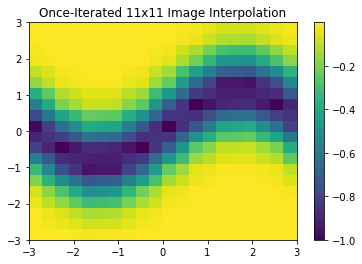

In [13]:
a = increase_density(x_edges)
b = increase_density(y_edges)
c = increase_density(z_test)
        
plt.pcolormesh(a, b, c)
plt.colorbar()
plt.title('Once-Iterated 11x11 Image Interpolation')
plt.show()

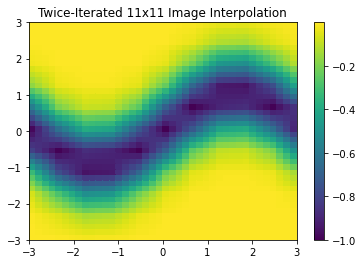

In [14]:
z_naivedense = increase_density(c)

plt.pcolormesh(xnew_edges, ynew_edges, z_naivedense)
plt.colorbar()
plt.title('Twice-Iterated 11x11 Image Interpolation')
plt.show()

Computing relative error of each form of interpolation, while holding constant the ratio of interpolated points to known points (15:1):
$$\text{Relative error} = \frac{|\tilde{f}(x) - f(x)|}{|f(x)|}$$

In [15]:
x = np.linspace(-3, 3, 41)
y = np.linspace(-3, 3, 41)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# I throw out the last row and column because not all these matrices are exactly the same size
# I also throw out the first sqrt(m) columns because of the error in the spline method discussed above
mag = 0
obs_mag_spline = 0
obs_mag_jank = 0
i = 7
while(i < len(Z)-1):
    for j in range(len(Z[0])-1):
        mag += Z[i][j]
        obs_mag_spline += znew[i][j]
        obs_mag_jank += z_naivedense[i][j]
    i += 1
        
spline_error = np.abs((obs_mag_spline-mag)/mag)
jank_error = np.abs((obs_mag_jank-mag)/mag)
print("Spline error for 10x10: ", spline_error)
print("Averaging error for 10x10: ", jank_error)

Spline error for 10x10:  0.14669096333622791
Averaging error for 10x10:  0.16053158342040574


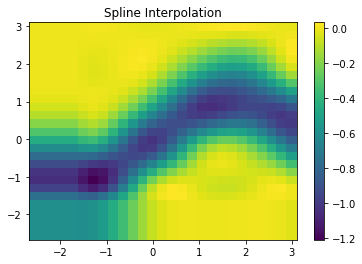

In [16]:
x_edges, y_edges = np.mgrid[-3:3:8j, -3:3:8j]
x = x_edges[:-1, :-1] + np.diff(x_edges[:2, 0])[0]*1.5
y = y_edges[:-1, :-1] + np.diff(y_edges[0, :2])[0] *1.5
z = f(x,y)
xnew_edges, ynew_edges = np.mgrid[-3:3:29j, -3:3:29j]
xnew = xnew_edges[:-1, :-1] + np.diff(xnew_edges[:2, 0])[0] *1.5
ynew = ynew_edges[:-1, :-1] + np.diff(ynew_edges[0, :2])[0] *1.5
tck = interp.bisplrep(x, y, z, s=0)
znew = interp.bisplev(xnew[:,0], ynew[0,:], tck)
plt.pcolormesh(xnew, ynew, znew, shading='auto')
plt.title('Spline Interpolation')
plt.colorbar()
plt.show()

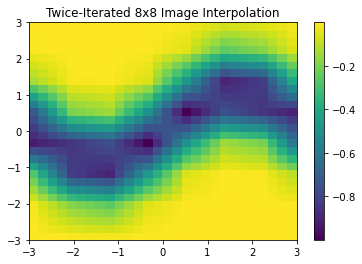

In [17]:
z_test = np.zeros((8, 8))
for i in range(8):
    for j in range(8):
        z_test[i][j] = f(x_edges[i][j], y_edges[i][j])
        
a = increase_density(increase_density(x_edges))
b = increase_density(increase_density(y_edges))
c = increase_density(increase_density(z_test))
plt.pcolormesh(a, b, c)
plt.colorbar()
plt.title('Twice-Iterated 8x8 Image Interpolation')
plt.show()

In [18]:
x = np.linspace(-3, 3, 29)
y = np.linspace(-3, 3, 29)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# I throw out the last row and column because not all these matrices are exactly the same size
# I also throw out the first sqrt(m) columns because of the error in the spline method discussed above
mag = 0
obs_mag_spline = 0
obs_mag_jank = 0
i = 7
while(i < len(Z)-1):
    for j in range(len(Z[0])-1):
        mag += Z[i][j]
        obs_mag_spline += znew[i][j]
        obs_mag_jank += c[i][j]
    i += 1
        
spline_error = np.abs((obs_mag_spline-mag)/mag)
jank_error = np.abs((obs_mag_jank-mag)/mag)
print("Spline error for 10x10: ", spline_error)
print("Averaging error for 10x10: ", jank_error)

Spline error for 10x10:  0.17560250862672425
Averaging error for 10x10:  0.20778149053023237


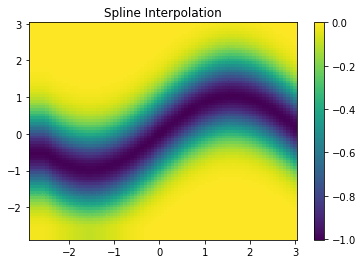

In [19]:
x_edges, y_edges = np.mgrid[-3:3:21j, -3:3:21j]
x = x_edges[:-1, :-1] + np.diff(x_edges[:2, 0])[0]*1.5
y = y_edges[:-1, :-1] + np.diff(y_edges[0, :2])[0] *1.5
z = f(x,y)
xnew_edges, ynew_edges = np.mgrid[-3:3:81j, -3:3:81j]
xnew = xnew_edges[:-1, :-1] + np.diff(xnew_edges[:2, 0])[0] *1.5
ynew = ynew_edges[:-1, :-1] + np.diff(ynew_edges[0, :2])[0] *1.5
tck = interp.bisplrep(x, y, z, s=0)
znew = interp.bisplev(xnew[:,0], ynew[0,:], tck)
plt.pcolormesh(xnew, ynew, znew, shading='auto')
plt.title('Spline Interpolation')
plt.colorbar()
plt.show()

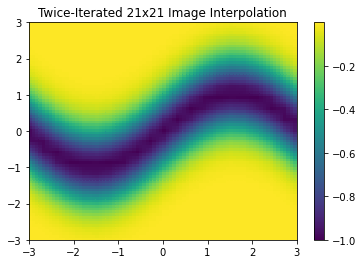

In [20]:
z_test = np.zeros((21, 21))
for i in range(21):
    for j in range(21):
        z_test[i][j] = f(x_edges[i][j], y_edges[i][j])
        
a = increase_density(increase_density(x_edges))
b = increase_density(increase_density(y_edges))
c = increase_density(increase_density(z_test))
plt.pcolormesh(a, b, c)
plt.colorbar()
plt.title('Twice-Iterated 21x21 Image Interpolation')
plt.show()

In [21]:
x = np.linspace(-3, 3, 81)
y = np.linspace(-3, 3, 81)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# I throw out the last row and column because not all these matrices are exactly the same size
# I also throw out the first sqrt(m) columns because of the error in the spline method discussed above
mag = 0
obs_mag_spline = 0
obs_mag_jank = 0
i = 7
while(i < len(Z)-1):
    for j in range(len(Z[0])-1):
        mag += Z[i][j]
        obs_mag_spline += znew[i][j]
        obs_mag_jank += c[i][j]
    i += 1
        
spline_error = np.abs((obs_mag_spline-mag)/mag)
jank_error = np.abs((obs_mag_jank-mag)/mag)
print("Spline error for 10x10: ", spline_error)
print("Averaging error for 10x10: ", jank_error)

Spline error for 10x10:  0.08284959203778855
Averaging error for 10x10:  0.08479334411505518


Both of these methods have notable drawbacks, in that the input data needs to be well-organized and relatively complete. It will not work like some interpolation methods that allow for randomly selected datapoints from all over the surface of a function. 

Overall, Spline interpolation (with the exception of the first 7ish columns of each output) marginally outperformed a crude and naive averaging function, which is to be expected for a sample curve such as the one used for this project. Given a more complex curve that has rapid topology fluxuations, I would expect the naive approach to underperform, while the spline approach would work comparitively better. This is because the spline interpolation method does not just take the values of the points given, but also takes into account the derivative, second derivative, and even third derivative in order to more accurately compute unknown values.

The advantages of the spline approach is that with a relatively complete dataset, one can more accurately account for fluxuations on a surface than a variety of other methods.
However, the drawbacks of the spline approach are arguably even more clear: It requires much more well-organized input data that if gathered in practice would be much more time and resource intensive.